# Experiment Tracking

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/mlops/03-mlflow.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

Manual tracking, e.g. with spreadsheets, is error prone, not standardized, has low visibility, and difficult for teams to collaborate over. In this module, we will look **experiment tracking** and **model management** using [MLflow](https://mlflow.org/). This platform provides a framework for storing artifacts such as environment and models, and tracking config parameters and source code, which are important for reproducing our experiments and performing inference with trained models. MLflow also has features for managing which models should go in and out of production.

In [1]:
!mlflow --version

mlflow, version 2.3.0


## MLflow on localhost 

Running the MLflow server on [localhost](https://mlflow.org/docs/latest/tracking.html#scenario-3-mlflow-on-localhost-with-tracking-server) port 5001 with a remote artifact store on S3:

```bash
$ mlflow server -h 127.0.0.1 -p 5001 \
    --backend-store-uri=sqlite:///mlflow.db \
    --default-artifact-root=s3://mlflow-artifact-store-3000
    
[2023-06-04 19:03:37 +0800] [38178] [INFO] Starting gunicorn 20.1.0
[2023-06-04 19:03:37 +0800] [38178] [INFO] Listening at: http://127.0.0.1:5001 (38178)
[2023-06-04 19:03:37 +0800] [38178] [INFO] Using worker: sync
[2023-06-04 19:03:37 +0800] [38179] [INFO] Booting worker with pid: 38179
[2023-06-04 19:03:37 +0800] [38180] [INFO] Booting worker with pid: 38180
[2023-06-04 19:03:37 +0800] [38181] [INFO] Booting worker with pid: 38181
[2023-06-04 19:03:37 +0800] [38182] [INFO] Booting worker with pid: 38182
```

```{figure} https://mlflow.org/docs/latest/_images/scenario_3.png
---
width: 80%
---
Our local setup with SQLite backend. But with a remote artifact store on AWS S3.
```

**Remark.** The remote artifact store (i.e. objects stored to reproduce each run of the experiment) can be also stored in the local file system. However, a remote artifact store on S3 would be convenient for loading trained models in environments without access to our local file system. An S3 bucket in AWS can be easily created using:

```
aws s3api create-bucket --bucket mlflow-artifact-store-3000
```

We will use [code](https://github.com/particle1331/ride-duration-prediction/tree/mlflow) and [data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) from the [previous module](01-intro/modeling-ride-duration) in our experiments.

In [2]:
!pip install -U git+https://github.com/particle1331/ride-duration-prediction.git@mlflow --upgrade --force-reinstall > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/particle1331/ride-duration-prediction.git /private/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/pip-req-build-8tt7fe30
  Running command git checkout -b mlflow --track origin/mlflow
  Switched to a new branch 'mlflow'
  branch 'mlflow' set up to track 'origin/mlflow'.


**Remark.** Our experiment scripts are in the [`ride_duration.experiments`](https://github.com/particle1331/ride-duration-prediction/tree/mlflow/ride_duration/experiment) module.

```{figure} ../../img/mlops/03-mlflow.png
---
---
MLflow UI on `localhost:5001`. An experiment is automatically created using `mlflow.set_experiment()` for the first run (see below).
```

## Experiment tracking

The utils script consists of boilerplate for setting up the **runs**. It also contains utilities around feature engineering and logging. This standardizes data and feature engineering so that the results are comparable. Here `feature_pipe` takes in a sequence of transformations that is applied left to right on the data. The resulting data frame is converted to a list of dictionary features which are then vectorized.

In [3]:
# experiment/utils.py
!pygmentize -g ~/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/ride_duration/experiment/utils.py

import time
from pathlib import Path

import mlflow
import pandas as pd
from toolz import compose
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

from ride_duration.utils import plot_duration_histograms
from ride_duration.config import config

ROOT_DIR = Path(__file__).parents[1]
DATA_DIR = ROOT_DIR / "data"
EXPERIMENT_NAME = "nyc-green-taxi"
TRACKING_URI = "http://127.0.0.1:5001"


def setup_experiment():
    mlflow.set_tracking_uri(TRACKING_URI)
    mlflow.set_experiment(EXPERIMENT_NAME)


def data_dict(debug=False):
    train_data_path = DATA_DIR / "green_tripdata_2021-01.parquet"
    valid_data_path = DATA_DIR / "green_tripdata_2021-02.parquet"
    train_data = pd.read_parquet(train_data_path)
    valid_data = pd.read_parquet(valid_data_path)

    return {
        "train_data": train_data if not debug else train_data[:100],
        "

As in the previous notebook, we train on one month and predict on the next. The following runs on our **baseline** linear regression model. This should reproduce results from the previous notebooks. All code inside the context forms a single run:

In [4]:
# experiment/linear.py
!pygmentize -g ~/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/ride_duration/experiment/linear.py

import os

import mlflow
from sklearn.linear_model import LinearRegression

from ride_duration.processing import preprocess
from ride_duration.experiment.utils import (
    data_dict,
    feature_pipeline,
    setup_experiment,
    mlflow_default_logging,
)

setup_experiment()
data = data_dict(debug=int(os.environ["DEBUG"]))


with mlflow.start_run():
    # Preprocessing
    X_train, y_train = preprocess(data["train_data"], target=True, filter_target=True)
    X_valid, y_valid = preprocess(data["valid_data"], target=True, filter_target=True)

    # Fit feature pipe
    feature_pipe = feature_pipeline()
    X_train = feature_pipe.fit_transform(X_train)
    X_valid = feature_pipe.transform(X_valid)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # MLflow logging
    MODEL_TAG = "linear"
    mlflow_default_logging(model, MODEL_TAG, data, X_train, y_train, X_valid, y_valid)


The next run modifies the above script with some feature engineering. This can be done by simply passing transformations (i.e. `f: df -> df`) as argument to the `feature_pipeline`:

```python
with mlflow.start_run():
    ...
    
    # Feature engineering + selection
    transforms = [add_pudo_column, feature_selector]

    # Fit feature pipe
    feature_pipe = feature_pipeline(transforms)
    ...
```

The complete script is as follows:

In [5]:
# experiment/linear_pudo.py
!pygmentize -g ~/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/ride_duration/experiment/linear_pudo.py

import os

import mlflow
from sklearn.linear_model import LinearRegression

from ride_duration.processing import preprocess
from ride_duration.experiment.utils import (
    data_dict,
    add_pudo_column,
    feature_pipeline,
    feature_selector,
    setup_experiment,
    mlflow_default_logging,
)

setup_experiment()
data = data_dict(debug=int(os.environ["DEBUG"]))


with mlflow.start_run():
    # Preprocessing
    X_train, y_train = preprocess(data["train_data"], target=True, filter_target=True)
    X_valid, y_valid = preprocess(data["valid_data"], target=True, filter_target=True)

    # Feature engineering + selection
    transforms = [add_pudo_column, feature_selector]

    # Fit feature pipe
    feature_pipe = feature_pipeline(transforms)
    X_train = feature_pipe.fit_transform(X_train)
    X_valid = feature_pipe.transform(X_valid)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # MLflow logging
    MODEL_TAG = "linear-pudo"
    mlflow_defaul

After running this script, we see the runs register in the UI with the logged data. It is also able to obtain other metadata such as its `git` commit hash. It is therefore best practice to always commit before running experiments. This requires running smaller examples of your scripts when prototyping (e.g. `export DEBUG=1` in our implementation). You can also store the script as an artifact.

```{figure} ../../img/mlops/03-runs.png
---
---
Our two runs in the MLflow UI. Clicking on `rmse_valid` column sorts the runs based on validation RMSE.
```

```{figure} ../../img/mlops/03-run-details.png
---
---
Details of one run. Default parameters are logged.
```

### Autologging

In this section, we show how to iterate over different models. This really just involves wrapping the run function in a loop. We also enable **autologging** for scikit-learn models. Automatic logging allows you to log metrics, parameters, *and models* without the need for explicit log statements.

In [6]:
# experiment/sklearn_trees.py
!pygmentize -g ~/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/ride_duration/experiment/sklearn_trees.py

import os

import mlflow
from sklearn.ensemble import (
    ExtraTreesRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)

from ride_duration.processing import preprocess
from ride_duration.experiment.utils import (
    data_dict,
    feature_pipeline,
    setup_experiment,
    mlflow_default_logging,
)

setup_experiment()
mlflow.sklearn.autolog()  # (!)
data = data_dict(debug=int(os.environ["DEBUG"]))


def run(model_class):
    with mlflow.start_run():
        # Preprocessing
        train = data["train_data"]
        valid = data["valid_data"]
        X_train, y_train = preprocess(train, target=True, filter_target=True)
        X_valid, y_valid = preprocess(valid, target=True, filter_target=True)

        # Fit feature pipe
        feature_pipe = feature_pipeline()
        X_train = feature_pipe.fit_transform(X_train)
        X_valid = feature_pipe.transform(X_valid)

        # Fit model
        model = model_class()
        model.fit(X_train, y_train)

        # 

`RandomForestRegressor` has the best validation score:

```{figure} ../../img/mlops/03-ensembles.png
---
---
```

Notice an increase in parameter count which were automatically logged. Autologging also creates the `MLmodel` which we look at shortly (also notice Models column). It also creates config files such as `conda.yaml` which describe the environment used to run the scripts. This indicates the expected input and output for the model and allows easy loading as indicated:

```{figure} ../../img/mlops/03-skautolog.png
---
---
```

### TPE with XGBoost

Trying out XGBoost next (i.e. tabular data silver bullet). We show how to perform hyperparameter optimization using Optuna. Here the parameters are sampled sequentially using the [TPE algorithm](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) over the search space defined in the `params` dictionary. This algorithm tends to be more cost-effective than grid and random search as shown in the [Appendix: TPE](03-mlflow-experiment/appendix/TPE) below. Each run corresponds to a choice of hyperparameters which corresponds to a `trial` in the Optuna framework.

In [7]:
# experiment/xgboost_optuna.py
!pygmentize -g ~/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/ride_duration/experiment/xgboost_optuna.py

import os

import mlflow
import optuna
from xgboost import XGBRegressor

from ride_duration.processing import preprocess
from ride_duration.experiment.utils import (
    data_dict,
    add_pudo_column,
    feature_pipeline,
    feature_selector,
    setup_experiment,
    mlflow_default_logging,
)

setup_experiment()
mlflow.xgboost.autolog()
data = data_dict(debug=int(os.environ["DEBUG"]))


def run(params: dict, pudo: int):
    with mlflow.start_run():
        # Preprocessing
        train = data["train_data"]
        valid = data["valid_data"]
        X_train, y_train = preprocess(train, target=True, filter_target=True)
        X_valid, y_valid = preprocess(valid, target=True, filter_target=True)

        # Fit feature pipe
        transforms = [add_pudo_column, feature_selector] if pudo else []
        feature_pipe = feature_pipeline(transforms)
        X_train = feature_pipe.fit_transform(X_train)
        X_valid = feature_pipe.transform(X_valid)

        # Fit model
        model =

Note that we use a flag `pudo` on whether to use the interaction feature between endpoint location IDs instead of each location considered separately. This is part of trial parameters so that more runs will be allocated to the setting works better with other parameters. XGBoost runs can be filtered out using `tags.model = 'xgboost'`:

```{figure} ../../img/mlops/03-xgboost-runs.png
---
---
Runs on the XGBoost model with autologging.
```

```{figure} ../../img/mlops/03-xgboost-intermediate.png
---
---
Comparing validation RMSE curves for 10 runs of the XGBoost model.
```

Below we look at visualizations of hyperparameter interaction:

```{figure} ../../img/mlops/03-pudo-boxplot.png
---
---
Analyzing the effect of the feature engineering step of using the `PU_DO` column only on model performance instead of `PULocationID` and `DOLocationID` separately. Seems like not using it is better. This is a tree-based model after all.
```

```{figure} ../../img/mlops/03-parallel.png
---
---
Filtering out high-performing settings in the parallel coordinates plot.
```

```{figure} ../../img/mlops/03-depth-mcw.png
---
---
Contour plot to visualize interaction of `max_depth` and `min_child_weight`.
```

## Model management

```{margin}
[MLflow models](https://www.mlflow.org/docs/latest/models.html)
```
Recall autologging generates an `MLmodel` file as well as files for approximating the environment used to generate the models. The unique `run_id` that corresponds to a directory in the artifacts store is assigned to each run allows for easily loading these models in remote environments. Note that even code for training these models can optionally be added as artifacts. See [docs](https://mlflow.org/docs/latest/python_api/mlflow.pyfunc.html).

```{figure} ../../img/mlops/03-mlmodel.png
---
name: 03-mlmodel
---
MLflow model information for the XGBoost model. Note the scikit-learn based feature pipeline also has its own section. Moreover, observe that MLflow provides a uniform API for loading these models using the `mlflow.pyfunc.load_model` function.
```

### Remote model loading

Note that a path to the model is provided [above](03-mlmodel). Loading the model from S3:

In [8]:
import mlflow

MODEL_URI = "s3://mlflow-artifact-store-3000/1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/model"
mlflow.pyfunc.load_model(MODEL_URI)

2023/06/06 23:54:08 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - psutil (current: uninstalled, required: psutil==5.9.5)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: 7b9ea2a58957491b92a42d8ec593f8fc

Folder structure in S3 is as shown in the [figure](03-mlmodel):

In [9]:
!aws s3 ls s3://mlflow-artifact-store-3000/1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/ --recursive --human-readable

2023-06-06 22:09:23    6.8 KiB 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_importance_weight.json
2023-06-06 22:09:17  320.0 KiB 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_importance_weight.png
2023-06-06 22:09:41  312 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_pipe/MLmodel
2023-06-06 22:09:42  362 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_pipe/conda.yaml
2023-06-06 22:09:42   14.1 KiB 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_pipe/model.pkl
2023-06-06 22:09:40  122 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_pipe/python_env.yaml
2023-06-06 22:09:40  217 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/feature_pipe/requirements.txt
2023-06-06 22:09:26  676 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/model/MLmodel
2023-06-06 22:09:35  252 Bytes 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/model/conda.yaml
2023-06-06 22:09:27    9.2 MiB 1/7b9ea2a58957491b92a42d8ec593f8fc/artifacts/model/model.xgb
2023-

The feature pipeline can therefore be loaded similarly:

In [10]:
ARTIFACTS_STORE  = "s3://mlflow-artifact-store-3000"
EXPERIMENT_ID    = "1"
RUN_ID           = "7b9ea2a58957491b92a42d8ec593f8fc"
ARTIFACTS_PATH   = f"{ARTIFACTS_STORE}/{EXPERIMENT_ID}/{RUN_ID}/artifacts"
MODEL_URI        = f"{ARTIFACTS_PATH}/model"
FEATURE_PIPE_URI = f"{ARTIFACTS_PATH}/feature_pipe"

# Loading models from S3
model = mlflow.pyfunc.load_model(MODEL_URI)
feature_pipe = mlflow.sklearn.load_model(FEATURE_PIPE_URI)

2023/06/06 23:55:33 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - psutil (current: uninstalled, required: psutil==5.9.5)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


The models can then be used to make inference:

In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from ride_duration.processing import preprocess

# Load data from some data source
data = pd.read_parquet("data/green_tripdata_2021-02.parquet")

# Inference on validation data
X, y = preprocess(data, target=True, filter_target=True)
X = feature_pipe.transform(X)
y_pred = model.predict(X)
print(mean_squared_error(y, y_pred) ** 0.5) # Expected: ~6.108

6.107853695857164


**Remark.** The same code can be used to make inference using any other model trained in the `nyc-green-taxi` experiment (e.g. the scikit-learn based models). Or any feature engineering steps since these are baked into the `feature_pipe` model.

### Model registry

Consider the scenario where a member of our team chooses a new model for production. As deployment engineers, we naturally have the following questions in mind: What has changed in this new model? Is there any preprocessing needed? What are the dependencies? Without experiment tracking, this requires a lot of back and fort communication. If there is an incident and we had to rollback the model version, we have to manually trace what changed in this new version. Moreover, it might not be possible to get back the previous model as information of how it was trained has been lost. 

Our tracking database and standard model files, solves most of these issues. Having a **model registry** takes care of the last details of model release and staging. If we want to rollback models, we only have to look at the archived models, or earlier versions, which also have their own [model lineage](https://aws.amazon.com/blogs/machine-learning/model-and-data-lineage-in-machine-learning-experimentation/). It is also natural to update models trained on the same task since models typically degrades with time or improve with new techniques so that registering a model with multiple versions that correspond to runs make sense.

```{margin}
[Source: `neptune.ai`](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Model-registry-overview.png?ssl=1)
```
```{figure} https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Model-registry-overview.png?ssl=1
---
width: 80%
---
Registering models into stages allows identification for QA and downstream tasks.
```

Suppose we need fast models. We can take the [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) of predict time and validation RMSE. Also taking the nearest model on the right which has better RMSE but is about 10x slower. We imagine this to be an update to the first model.

```{figure} ../../img/mlops/03-pareto-front.png
---
width: 80%
---
Two models at the Pareto front of valid RMSE and predict time.
```

Registering this model can be done by simply clicking the "Register Model" button in the UI. Later we will see how this can be done in code. We choose the name `nyc-green-taxi-ride-duration` and we stage this is production. The latter model is set to staging. The model registry can be viewed in the Models tab of the UI.

```{figure} ../../img/mlops/03-registered-versions.png
---
---
Registering a model and staging a new version of the model trained on the same task.
```


```{figure} ../../img/mlops/03-register-archive.png
---
---
Transitioning the staged model to production and the current prod model to archived.
```


**Remark.** Note that experiment runs does not always need to involve model training.
It can consist of evaluation tasks for large pretrained models on a variety
of tasks or datasets. 

## API Workflows

In this section, we look at how to programatically interact with the MLflow server through its client. The idea is that everything that we can do in the UI by clicking buttons, we should be able to do here in code. And the fields that are available using the UI correspond to function arguments of the corresponding API endpoint or client method.

### Experiment tracking

The `MlflowClient` connects to the experiment tracking server. This provides a [CRUD interface](https://en.wikipedia.org/wiki/Create,_read,_update_and_delete) for managing experiments and runs. For example, we can list all experiments.

In [104]:
from mlflow.tracking import MlflowClient

TRACKING_URI = "http://127.0.0.1:5001"
client = MlflowClient(tracking_uri=TRACKING_URI)

def print_experiment(experiment):
    print(f"(Experiment)")
    print(f"    experiment_id={experiment.experiment_id}")
    print(f"    name='{experiment.name}'")
    print(f"    artifact_location='{experiment.artifact_location}'")
    print()


for experiment in client.search_experiments():
    print_experiment(experiment)

(Experiment)
    experiment_id=1
    name='nyc-green-taxi'
    artifact_location='s3://mlflow-artifact-store-3000/1'

(Experiment)
    experiment_id=0
    name='Default'
    artifact_location='s3://mlflow-artifact-store-3000/0'



**Remark.** Here we have the SQLite file `mlflow.db` on disk. In practice, you may have a remote tracking database. This is covered in the [appendix](03-mlflow-experiment/appendix/AWS-deployment). But only the URI changes, the overall idea is the same.

In the previous section, we selected two best performing runs using the UI. This can be done with the client using the `search_runs` method. Note that MLflow stores even deleted experiments. So we specify `ViewType` to `ACTIVE_ONLY` in the search results.

In [105]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids=1,
    filter_string='metrics.predict_time < 3e-6 and metrics.predict_time < 6.20',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=15,
    order_by=["metrics.rmse_valid ASC", "metrics.predict_time ASC"]
)

for run in runs:
    name = run.info.run_name
    format_name = name + " " * (16 - len(name)) if len(name) <= 16 else name[:13] + "..."
    print(f"{format_name}  {run.info.run_id}  rmse_valid: {run.data.metrics['rmse_valid']:.3f}  predict_time: {run.data.metrics['predict_time']:.4e}")

capable-duck-138  ab1627e83ba54533a6cef8808fffa833  rmse_valid: 6.113  predict_time: 1.9263e-06
welcoming-shr...  3b22785082064008970cca22d9437fc9  rmse_valid: 6.122  predict_time: 1.0417e-06
awesome-midge...  0dd2282af2ee4285883496f85de5391d  rmse_valid: 6.122  predict_time: 1.1373e-06
aged-shrimp-43    011a2ceeffd8456b9efe40c607fb316b  rmse_valid: 6.135  predict_time: 2.0041e-06
likeable-skin...  6b6d237b07124a18a5209a58644aa212  rmse_valid: 6.136  predict_time: 1.7963e-06
spiffy-ant-29     b94a01e596f04b18bef92ba57311558e  rmse_valid: 6.136  predict_time: 1.9076e-06
illustrious-f...  b4a2096903bc45349c8a7d157e3824d7  rmse_valid: 6.144  predict_time: 1.2170e-06
valuable-squi...  33e47ef0f9b44e92ab650aaf3e941e55  rmse_valid: 6.166  predict_time: 1.2816e-06
efficient-wol...  0235a03362a2467b8713b4598487182d  rmse_valid: 6.181  predict_time: 9.8972e-07
youthful-fox-525  a80338fa398e466ca80190b02c4a4923  rmse_valid: 6.195  predict_time: 6.3362e-07
auspicious-el...  c18f4798677241158c795d

This may give us better results than visual inspection when choosing models.

### Model registry

The following code puts a model into the registry. If the model name already exists, we get a new version. Otherwise it creates a new model in the model registry.

In [51]:
import mlflow

# Getting the first run in our above query
RUN_ID = runs[0].info.run_id
MODEL_URI = f"s3://mlflow-artifact-store-3000/1/{RUN_ID}/artifacts/model"

client.create_model_version(
    name="nyc-green-taxi-ride-duration",
    run_id=RUN_ID,
    source=MODEL_URI
);

2023/06/07 02:12:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-green-taxi-ride-duration, version 4


This version can be transitioned to staging as follows:

In [52]:
import datetime

def transition_stage(client, model_name, model_version, new_stage, archive_existing=False):
    """Transition version stage. Update description."""

    old_description = client.get_model_version(name=model_name, version=model_version).description or ''

    client.transition_model_version_stage(
        name=model_name,
        version=model_version,
        stage=new_stage,
        archive_existing_versions=archive_existing
    )

    client.update_model_version(
        name=model_name,
        version=model_version,
        description=f"[{datetime.datetime.now()}] The model version {model_version} was transitioned to {new_stage}.\n{old_description}"
    )


transition_stage(client, "nyc-green-taxi-ride-duration", 4, "Staging")

**Remark.** I messed up with version 3 (used an outdated API). Here we use version 4.

```{figure} ../../img/mlops/03-api-versions.png
---
---
```


```{figure} ../../img/mlops/03-create-version-api.png
---
---
```


The following lists the latest versions for each stage:

In [56]:
latest_versions = client.get_latest_versions(name="nyc-green-taxi-ride-duration")
for version in latest_versions:
    print(f"Version: {version.version}   Run ID: {version.run_id}   Stage: {version.current_stage}" )

Version: 1   Run ID: 3b22785082064008970cca22d9437fc9   Stage: Archived
Version: 2   Run ID: a80338fa398e466ca80190b02c4a4923   Stage: Production
Version: 4   Run ID: ab1627e83ba54533a6cef8808fffa833   Stage: Staging


The same transition function can be used to promote Version 4 to production and archive Version 3 which is currently in production. Note that we can automatically archive Version 2 using `archive_existing=True`. But we use the transition function so that the description is automatically updated.

In [57]:
transition_stage(client, "nyc-green-taxi-ride-duration", 4, "Production")
transition_stage(client, "nyc-green-taxi-ride-duration", 2, "Archived")

```{figure} ../../img/mlops/03-updated-versions.png
---
---
```

```{figure} ../../img/mlops/03-new-versions.png
---
---
```


### Inference with staged models

Here we load the latest model in from production. This can be used for example when an REST API initializes.

In [61]:
MODEL_NAME = "nyc-green-taxi-ride-duration"
STAGE = "Production"
RUN_ID = client.get_latest_versions(name=MODEL_NAME, stages=[STAGE])[0].run_id
ARTIFACTS_PATH = f"{ARTIFACTS_STORE}/{EXPERIMENT_ID}/{RUN_ID}/artifacts"
MODEL_URI = f"{ARTIFACTS_PATH}/model"
FEATURE_PIPE_URI = f"{ARTIFACTS_PATH}/feature_pipe"

# Loading models from S3
model = mlflow.pyfunc.load_model(MODEL_URI)
feature_pipe = mlflow.sklearn.load_model(FEATURE_PIPE_URI)

# Load data from some data source
data = pd.read_parquet("data/green_tripdata_2021-02.parquet")

# Inference on validation data
X, y = preprocess(data, target=True, filter_target=True)
X = feature_pipe.transform(X)
y_pred = model.predict(X)
print(mean_squared_error(y, y_pred) ** 0.5)

2023/06/07 02:58:05 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - psutil (current: uninstalled, required: psutil==5.9.5)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


6.112723434664211


In [67]:
client.get_run(RUN_ID).data.metrics

{'validation_0-rmse': 6.112723434263187,
 'stopped_iteration': 180.0,
 'best_iteration': 130.0,
 'rmse_train': 3.9657816519477587,
 'rmse_valid': 6.112723434664211,
 'predict_time': 1.926340814348688e-06}

Checks out.

**Remark.** MLflow seems to like working only with latest versions in the registry which makes sense. But it could be useful to have multiple models in staging. A workaround would be to retrieve the model by using the model version:

In [103]:
from datetime import datetime

runs = client.search_model_versions(f"name='{MODEL_NAME}'")
print(f"({MODEL_NAME})")
for run in runs:
    if run.current_stage == "Archived":
        last_updated = run.last_updated_timestamp / 1000    # ms
        print("\n  Version:", run.version)
        print("  Run ID:", run.run_id)
        print("  Stage:", run.current_stage)
        print("  Status:", run.status)
        print("  Last Modified:", datetime.fromtimestamp(last_updated).strftime('%Y-%m-%d %H:%M:%S'))

(nyc-green-taxi-ride-duration)

  Version: 2
  Run ID: a80338fa398e466ca80190b02c4a4923
  Stage: Archived
  Status: READY
  Last Modified: 2023-06-07 02:42:53

  Version: 1
  Run ID: 3b22785082064008970cca22d9437fc9
  Stage: Archived
  Status: READY
  Last Modified: 2023-06-07 01:21:56


(03-mlflow-experiment/appendix/TPE)=
## Appendix: TPE algorithm

Samplers which determine the sequence of trials are specified when creating a Optuna study: 

```python
study = create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler()
)
```


```{figure} ../../img/optuna-samplers.png
---
name: optuna-samplers
---
List of all [sampling algorithms](https://optuna.readthedocs.io/en/stable/reference/samplers.html) as of version 2.10.0.
```

Optuna uses  **Tree-Structured Parzen Estimater** (TPE) {cite}`bergstra` as the default sampler. This is a form of Bayesian optimization that samples each parameter independently. In general, we expect TPE to be more efficient than random search since the sampler chooses succeeding points in a principled way. To demonstrate TPE, we minimize the following objective function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


def plot_contour(f, title, ax, x_range, y_range, cmap=cm.cividis):
    """Generate 2d contour plot of function f with two parameters."""

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # Plot
    ax.contourf(X, Y, Z, cmap=cmap)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    return ax


def plot_surface(f, title, ax, x_range, y_range, cmap=cm.viridis):
    """Generate 3d surface plot {(x, y, f(x, y)) | x ∈ x_range, y ∈ y_range}."""

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # Plot    
    ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
    ax.set_zlabel("loss", rotation=90)
    
    # Formatting plot
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.title(title)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    plt.tight_layout()

    return ax


def plot_results(study, ax, p1, p2, f, x_range, y_range):
    """Scatter plot optimization steps with contour in background."""
    
    plot_contour(f, "objective", ax=ax, x_range=x_range, y_range=y_range)
    study.trials_dataframe().plot(
        kind='scatter', 
        ax=ax,
        figsize=(8, 4),
        color='C3', edgecolor='black',
        x='params_'+p1, y='params_'+p2,
        xlabel=p1, ylabel=p2
    )

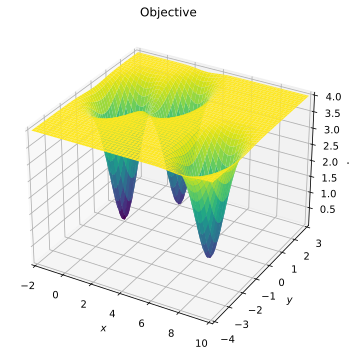

In [2]:
def f(x, y):
    """Flat surface with three holes."""
    r = 4.0
    center = [(0, 0), (3, 1), (8, -2)]
    factor = [-4.0, -3.5, -3.3]
    for j, c in enumerate(center):
        r += factor[j] * np.exp(-(x - c[0])**2 - (y - c[1])**2)
    return r


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plot_surface(f, title="Objective", x_range=(-2, 10), y_range=(-4, 3), ax=ax);

Note that from the color of the surface that we get better minimas for decreasing $\mathsf x.$

In [3]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -1, 9)
    y = trial.suggest_float('y', -3, 2)
    return f(x, y)


min_f = optuna.create_study(direction="minimize")
min_f.optimize(objective, n_trials=100) # TPE default sampler

/Users/particle1331/opt/miniconda3/envs/mlops/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-06-03 17:00:52,059] A new study created in memory with name: no-name-68e2e88c-7d0a-4762-91c3-81a6b2722b1c
[I 2023-06-03 17:00:52,060] Trial 0 finished with value: 3.919721891416322 and parameters: {'x': -0.6862934873070938, 'y': 1.8540712767191847}. Best is trial 0 with value: 3.919721891416322.
[I 2023-06-03 17:00:52,061] Trial 1 finished with value: 2.6412954903499806 and parameters: {'x': 2.157473988116001, 'y': 1.4893206162284152}. Best is trial 1 with value: 2.6412954903499806.
[I 2023-06-03 17:00:52,061] Trial 2 finished with value: 3.386073684842383 and parameters: {'x': 1.5307571248693184, 'y': 0.548234067592456}. Best is trial 1 with value: 2.6412954903499806.
[I 2023-06-03 17:00:52,062] Trial 3

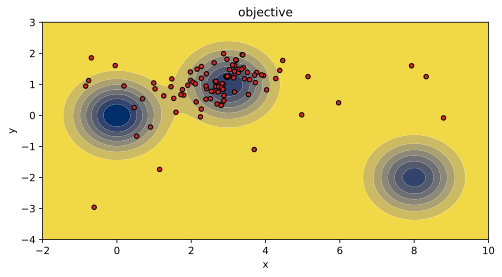

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_results(min_f, ax, 'x', 'y', f, x_range=(-2, 10), y_range=(-4, 3))

**What TPE sees.** TPE algorithm converges to a local minima (not necessarily the global one). To visualize what the optimizer "sees", we can look at the contour plot. Note that it was not fully aware of how deep the other two holes are since it barely touched them.

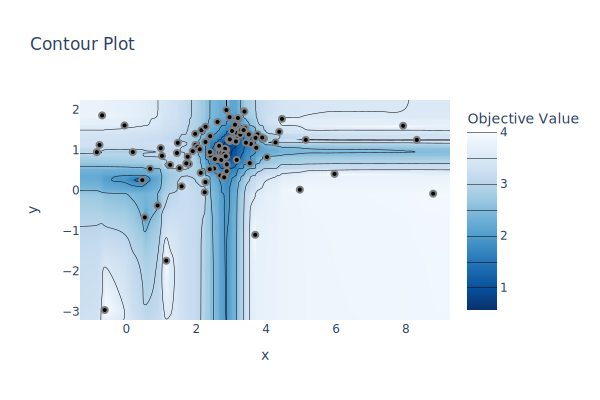

In [5]:
fig = optuna.visualization.plot_contour(min_f, params=["x", "y"])
fig.update_layout(width=600, height=400)
fig.show(renderer="svg")

(03-mlflow-experiment/appendix/AWS-deployment)=
## Appendix: AWS deployment

For storing runs and artifacts, MLflow uses two components for storage: **backend store** and **artifact store**. The backend store persists MLflow entities such as run metadata such as  parameters, metrics, and tags. These data can be queried and are best stored in a relational database. On the other hand, the artifact store persists files of arbitrary nature such as pickled models, images, and other in-memory objects. 

Recall that for our local setup, MLflow runs are tracked in a local SQLite database, and artifacts are persisted in S3. But the backend can be set to any SQLAlchemy compatible database. MLflow artifacts can be persisted a variety of remote file storage solutions. Here we will deploy MLflow on a remote tracking server in [EC2](https://aws.amazon.com/ec2/) and a remote PostgreSQL database in [RDS](https://aws.amazon.com/rds/). Creating an S3 bucket was covered above.

### EC2 Instance

**Launch instance.** Launch a t2.micro EC2 instance with name `mlflow-tracking-server` and with Amazon Linux 2 AMI (HVM) 64-bit (x86) OS in an IAM user. Create a new [key pair](https://particle1331.github.io/ok-transformer/nb/mlops/1-intro.html#renting-an-ec2-instance) so you can connect using SSH. Keep the default values for the other settings.

**Inbound rules.** Edit inbound rules in security groups. Our instance should accept incoming SSH (port 22) and HTTP connections (port 5000). Specify CIDR blocks to specify the range of IP addresses that has access to the tracking server, e.g. choose 'My IP' as source so only computers on your local network can access the server.

<br>

```{figure} ../../img/inbound-rules.png
---
name: ec2-inbound
---
Choosing `0.0.0.0/0` allows all incoming HTTP access.
```

### PostgreSQL DB

**Create database.** Go to the RDS console and click "Create database". Select PostgreSQL engine type. Select an identifier for your DB instance, e.g. `mlflow-backend-db` shown here. Set the master username as `mlflow`. Tick the option "Auto generate a password" so Amazon RDS generate a password automatically. Finally, on the section "Additional configuration" specify an initial database name, e.g. `mlflow_backend_db`, so RDS automatically creates an initial database for you. The generated password will be shown (only once) after the database has been created. You can use the default values for all the other configurations.

<br>

```{figure} ../../img/rds-template.png
---
width: 40em
---
Choosing an engine and template.
```

```{figure} ../../img/rds-identifier.png
---
width: 40em
---

```

```{figure} ../../img/rds-name.png
---
width: 40em
---
Choosing identifier, username, password, and initial database name. 
```

**Credentials.** Take note of the following information: master username (`DB_USERNAME`), password (`DB_PASSWORD`), initial database name (`DB_NAME`), and endpoint (`DB_ENDPOINT`). On the RDS dashboard, click on the database and look at "Connectivity & security". The endpoint for the database can be seen there. 

**Inbound rules.** Select the VPC security group of the DB under the same tab. Click the security group ID, and edit inbound rules by adding a new rule that allows PostgreSQL connections on the port 5432 from the security group of the EC2 instance for the tracking server. Note that the security group of the EC2 instance is `sg-049fa46c4cd030db2 - launch-wizard-2` as can be seen on the top of {numref}`ec2-inbound`. This way the tracking server will be able to connect to the PostgreSQL database. 

<br>

```{figure} ../../img/postgres.png
---
width: 40em
---

Allow postgres connections from the tracking server to the backend database.

```


### Server config and launch

Here we connect to the `mlflow-tracking-server` EC2 instance from our local terminal. In the local `.ssh` directory:

```bash
chmod 400 mlflow-tacking.pem
ssh -i "mlflow-tracking.pem" ec2-user@ec2-34-209-62-152.us-west-2.compute.amazonaws.com
```

Run the following commands to install the dependencies and configure the environment on the EC2 instance:

```
sudo yum update
pip3 install mlflow boto3 psycopg2-binary
aws configure   # Input your IAM credentials here
aws s3 ls       # Test if instance can access S3 bucket
```

Finally, launch the server by replacing the following with the appropriate database credentials. You can replace the variables below manually, or you can execute the following assignments for each variable, so that the values are automatically filled.

```bash
export DB_USER=mlflow
export DB_PASSWORD=ZbTddA0Zc8LxYcdLFUQr
export DB_ENDPOINT=mlflow-backend-database.csegt7oxppl.us-west-2.rds.amazonaws.com
export DB_NAME=mlflow_backend_database
export S3_BUCKET_NAME=mlflow-artifact-store-2

mlflow server -h 0.0.0.0 -p 5000 \
    --backend-store-uri=postgresql://${DB_USER}:${DB_PASSWORD}@${DB_ENDPOINT}:5432/${DB_NAME} \
    --default-artifact-root=s3://${S3_BUCKET_NAME}
```

### Trying it out

Since we are allowed by the inbound rules to send information via HTTP to the tracking server, we should be able to send requests to it. Note that everything that follows is done in our local Jupyter notebook. After setting the tracking URI we should be able to manage experiments and the model registry through the client as before. You may have to do `aws configure` for credentials in an external machine. 

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient


TRACKING_SERVER_HOST = "ec2-34-209-62-152.us-west-2.compute.amazonaws.com"
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

client = MlflowClient(tracking_uri=f"http://{TRACKING_SERVER_HOST}:5000")
print(client.list_experiments())
print(client.list_registered_models())

[]
[]


Running an example experiment.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


mlflow.set_experiment("iris")
X, y = load_iris(return_X_y=True)

for C in [10, 1, 0.1, 0.01, 0.001]:
    with mlflow.start_run(nested=True):

        params = {"C": C, "random_state": 42}
        
        lr = LogisticRegression(**params).fit(X, y)
        y_pred = lr.predict(X)

        mlflow.log_metric("accuracy", accuracy_score(y, y_pred))
        mlflow.log_params(params)
        mlflow.sklearn.log_model(lr, artifact_path="models")

2022/06/04 03:44:56 INFO mlflow.tracking.fluent: Experiment with name 'iris' does not exist. Creating a new experiment.


<br>

```{figure} ../../img/aws-runs.png
---
width: 40em
---

Runs are recorded in the tracking UI.

```


```{figure} ../../img/s3.png
---
width: 40em
---

We can see the runs artifacts stored in the S3 bucket.

```
